In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models
import tensorflow_datasets as tfds

ds,ds_info = tfds.load('food101',shuffle_files = True,as_supervised=True, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteV7KWGY/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteV7KWGY/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds, valid_ds = ds["train"], ds["validation"]

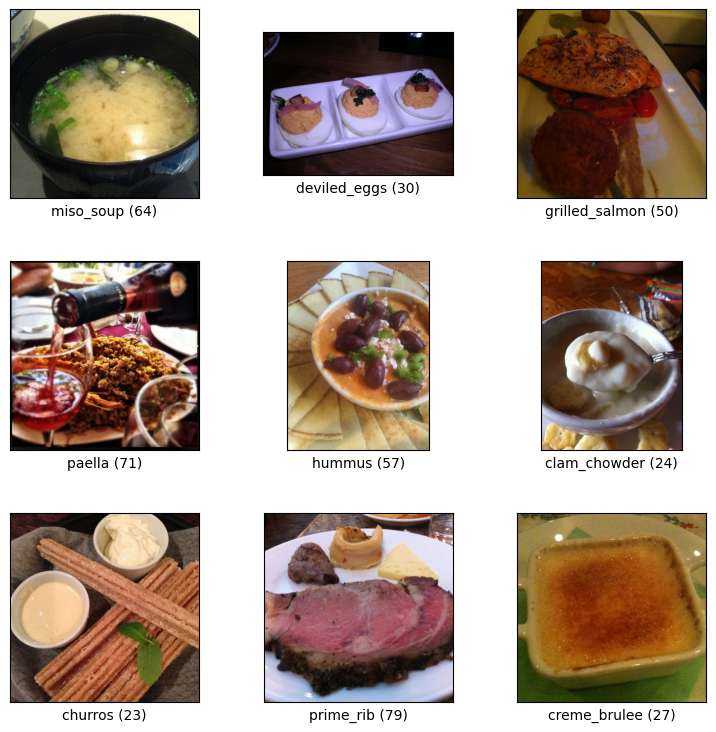

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image,[MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image,[MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, tf.int32))
)

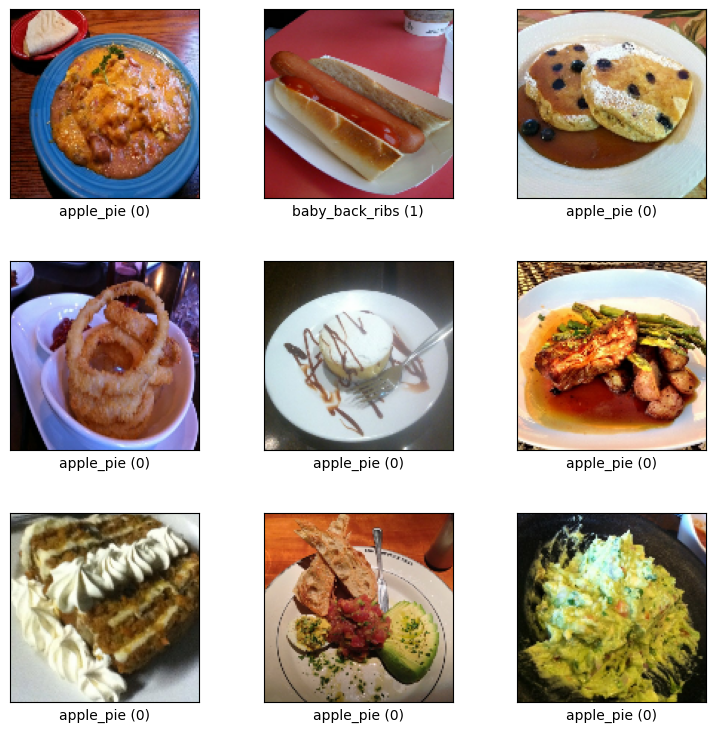

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [ ]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

In [ ]:
batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],[0.5, 0.5], stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[ 83  71  47]
   [ 84  71  49]
   [ 83  68  49]
   ...
   [181 179 138]
   [191 188 147]
   [182 179 138]]

  [[ 85  70  49]
   [ 85  69  49]
   [ 86  71  50]
   ...
   [187 185 146]
   [181 177 139]
   [189 185 147]]

  [[ 84  68  50]
   [ 88  74  55]
   [ 85  72  55]
   ...
   [199 197 158]
   [200 196 159]
   [192 188 150]]

  ...

  [[155 154 160]
   [156 155 161]
   [157 156 162]
   ...
   [ 88  89  76]
   [ 81  82  65]
   [ 90  88  73]]

  [[175 174 180]
   [168 166 173]
   [163 160 167]
   ...
   [ 85  86  73]
   [ 78  79  63]
   [ 77  76  58]]

  [[169 169 175]
   [151 150 156]
   [165 163 170]
   ...
   [ 72  74  60]
   [ 75  76  60]
   [ 74  73  55]]]


 [[[ 21  25  30]
   [ 23  25  30]
   [ 23  24  28]
   ...
   [ 37  35  48]
   [ 45  40  53]
   [ 56  41  53]]

  [[ 26  27  31]
   [ 23  23  28]
   [ 26  25  31]
   ...
   [ 37  36  47]
   [ 42  40  50]
   [ 52  43  51]]

  [[ 37  30  29]
   [ 34  27  27]
   [ 35  29  32]
   ...
   [ 42  39  50]
   [ 40  36  45]


Neural Net Implementation


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [ ]:
for i,_ in ds["train"].take(1):
  image = i

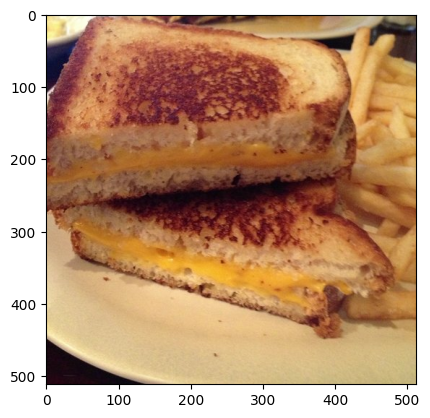

In [ ]:
plt.imshow(image)

In [ ]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image /= 255.0

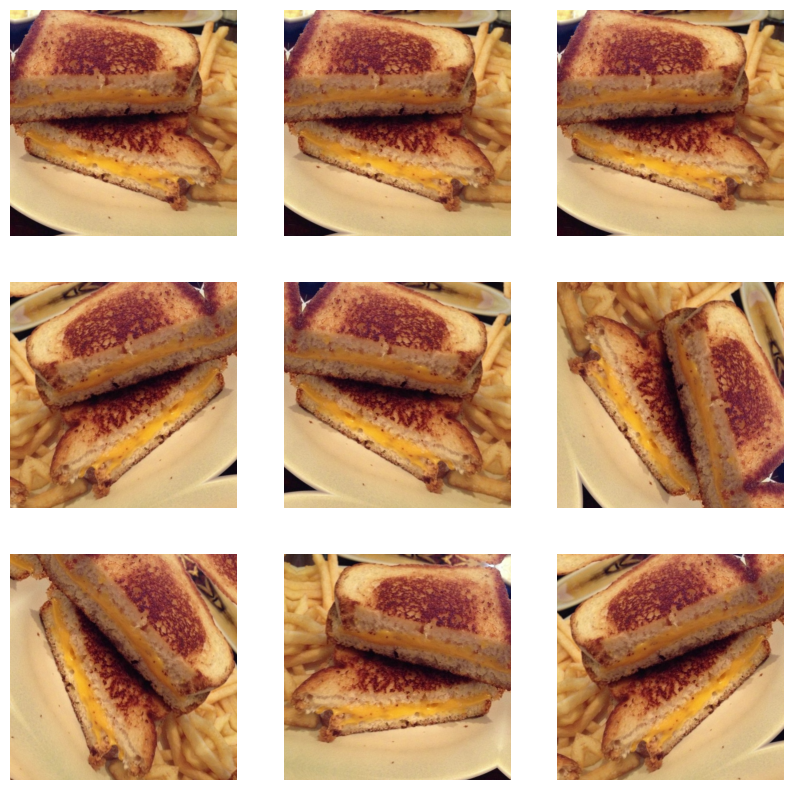

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3, i+1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64,(3,3), activation='relu', input_shape=[MAX_SIDE_LEN,MAX_SIDE_LEN,3]))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32,(3,3),activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [ ]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data= valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/10
    213/Unknown - 295s 1s/step - loss: 1.5015 - accuracy: 0.5021

In [ ]:
plt.figure(figsize=(10,10))
for iage_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

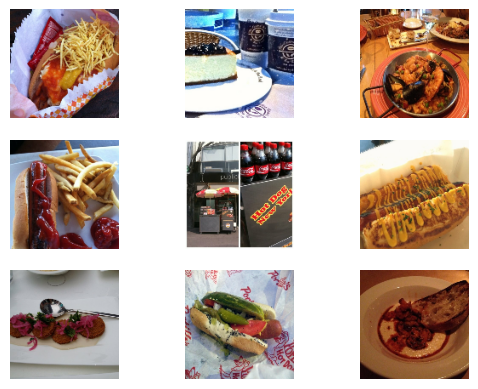

In [ ]:
for i in range(9):
  ax = plt.subplot(3,3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [ ]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)>